In [38]:
from uavsar_pytools import UavsarScene, UavsarImage
from uavsar_pytools.snow_depth_inversion import depth_from_phase, phase_from_depth
import xarray as xa
import rioxarray as rxa
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
from os.path import join
from whitebox_tools import WhiteboxTools

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [115]:
ds = xa.open_dataset('/Users/zachkeskinen/Documents/uavsar/data/dc_lidar/ds-lidar-us3.nc')
ds = ds.drop('spatial_ref')

In [116]:
ds['052_cor_HH-HV'] = ds['052_cor_HH']-ds['052_cor_HV']
ds['232_cor_HH-HV'] = ds['232_cor_HH']-ds['232_cor_HV']
ds['052_cor_HH-VV'] = ds['052_cor_HH']-ds['052_cor_VV']
ds['232_cor_HH-VV'] = ds['232_cor_HH']-ds['232_cor_VV']
ds['052_cor_HV-VV'] = ds['052_cor_HV']-ds['052_cor_VV']
ds['232_cor_HV-VV'] = ds['232_cor_HV']-ds['232_cor_VV']

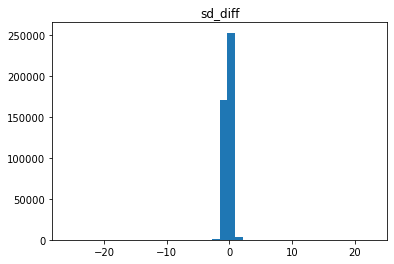

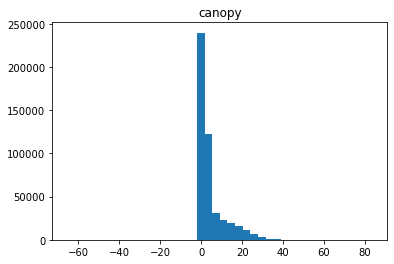

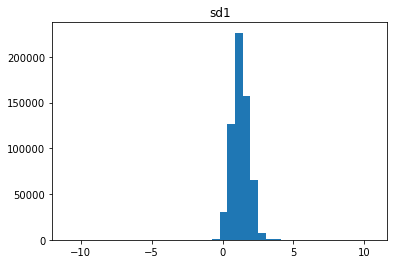

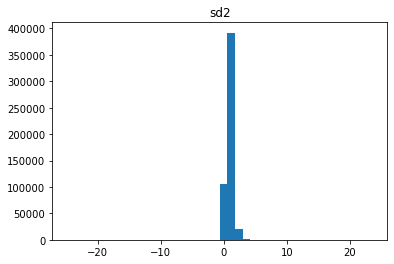

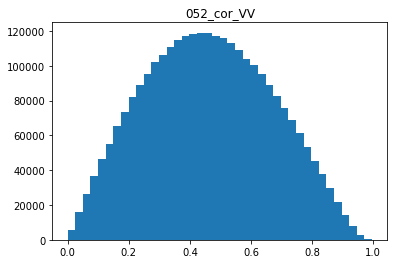

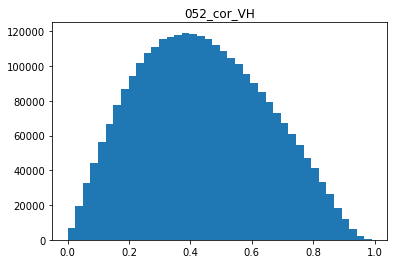

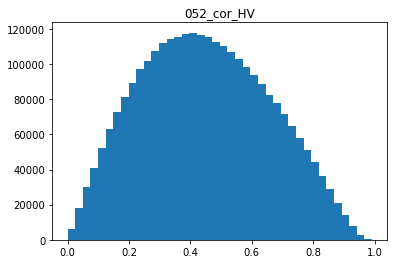

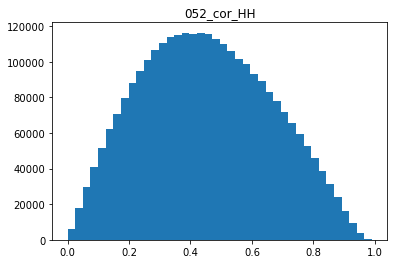

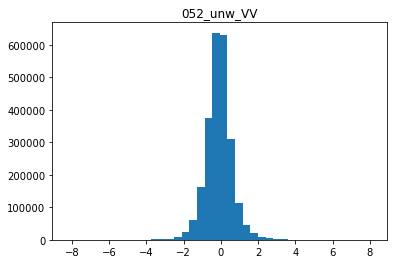

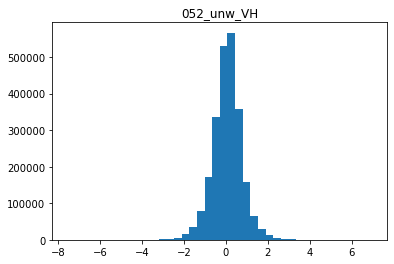

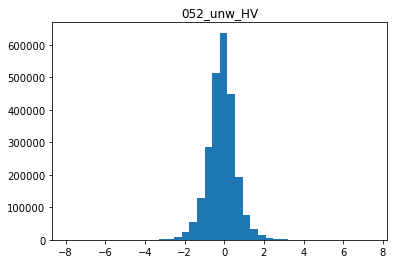

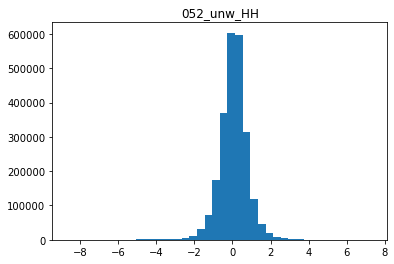

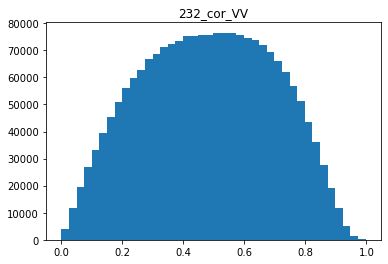

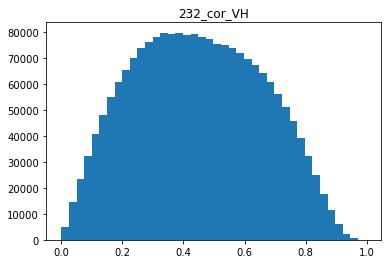

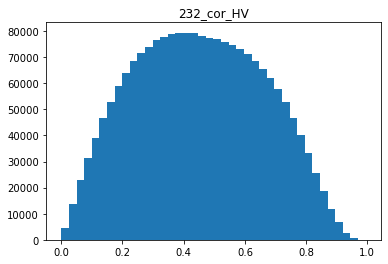

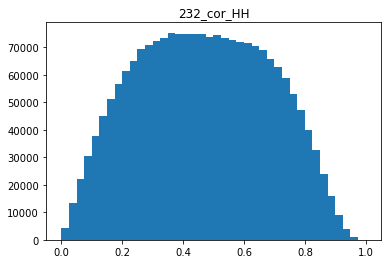

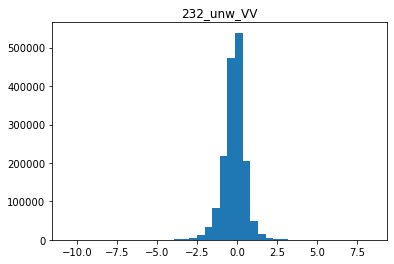

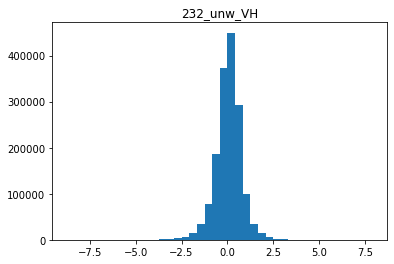

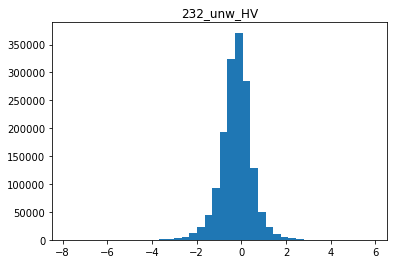

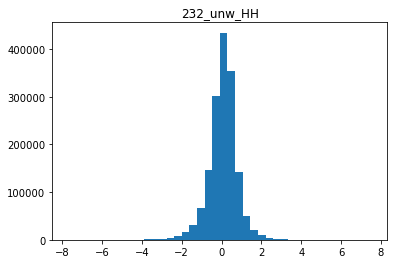

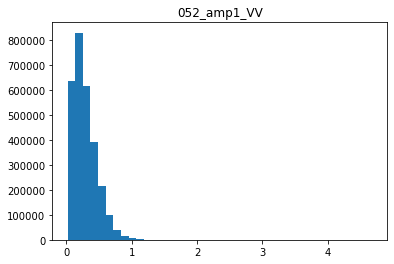

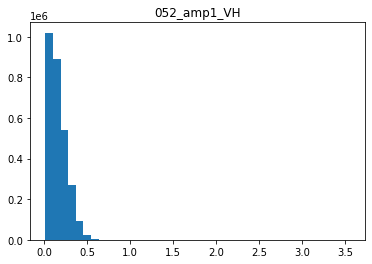

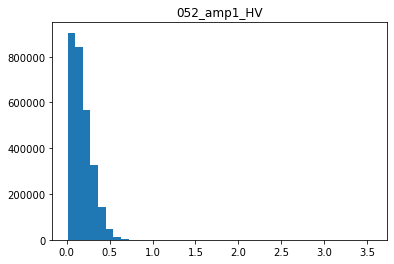

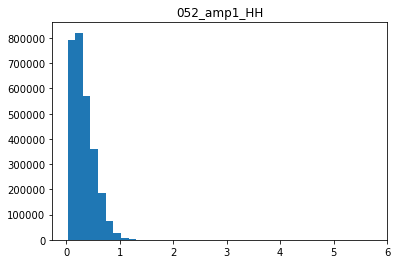

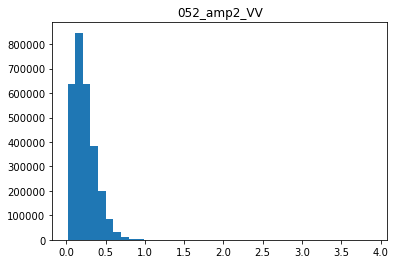

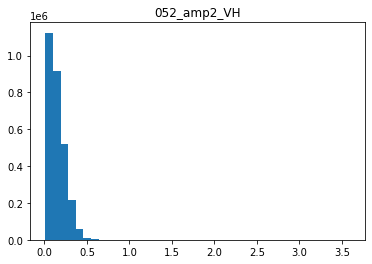

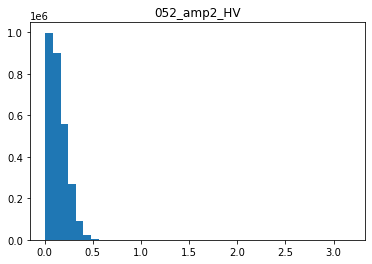

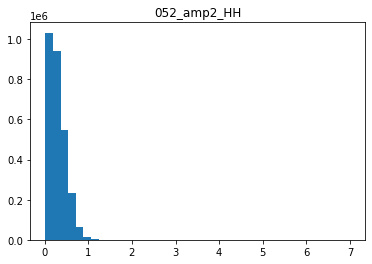

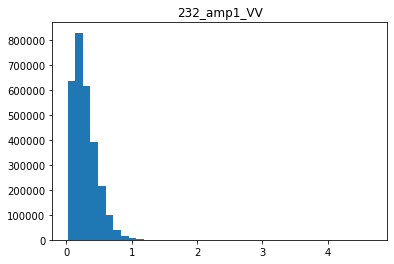

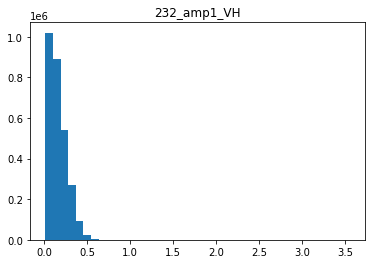

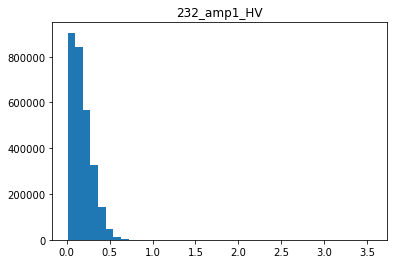

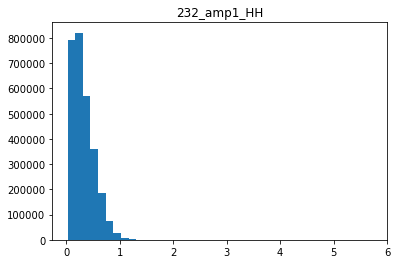

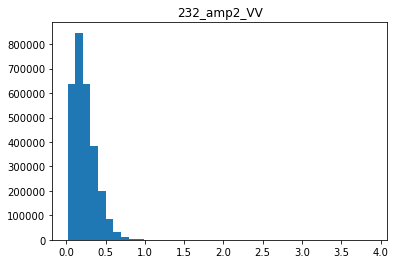

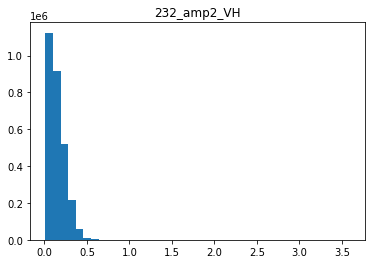

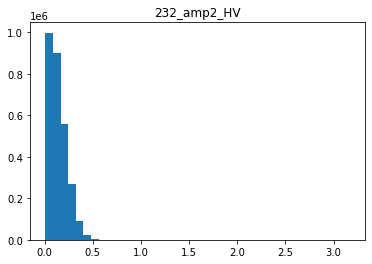

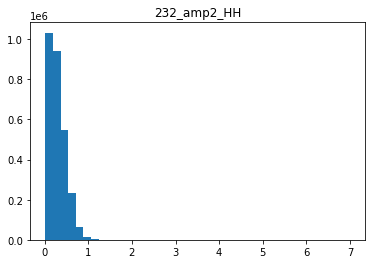

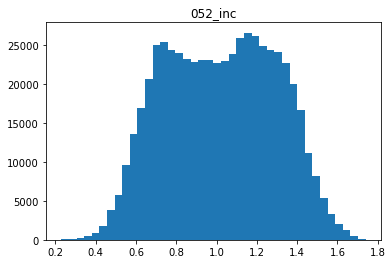

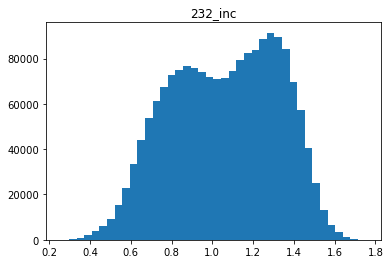

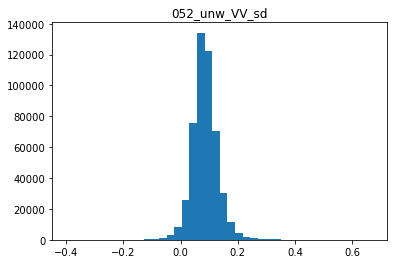

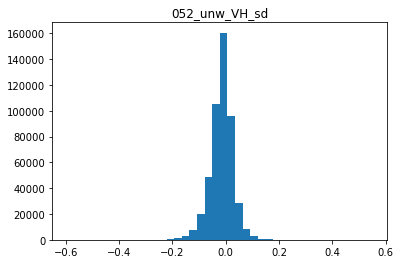

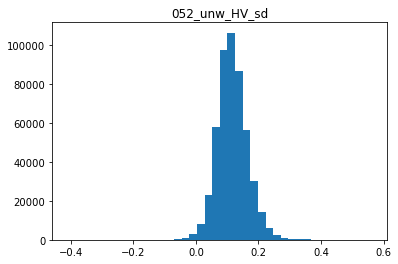

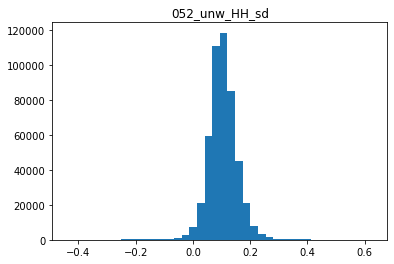

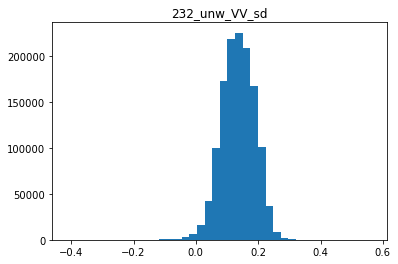

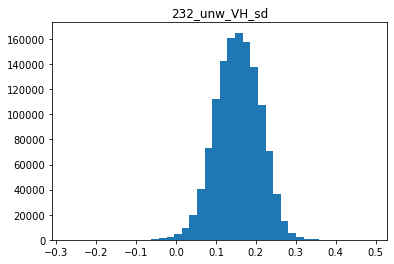

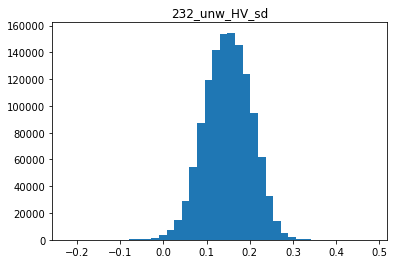

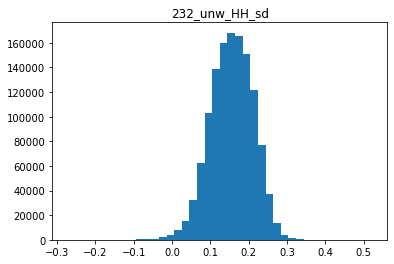

In [67]:
for name in ds:
    plt.hist(ds[name].values[0].ravel(), bins = 40)
    plt.title(name)
    plt.show()

In [117]:
FULL = pd.DataFrame()
for name in ds:
    FULL.loc[:,name]=ds[name].values.ravel()
FULL = FULL.dropna(axis = 0)
y = FULL.sd_diff
X = FULL.drop(['sd_diff','sd1','sd2','052_inc', '232_inc', 'canopy'], axis =1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 42)

numeric_features = X.columns
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

clf = Pipeline(steps=[('preprocessor', numeric_transformer),
                      ('classifier', RandomForestRegressor(max_depth=10, random_state=0))])

Training score:  0.5116966976359854
Testing score:  0.10499045459002443


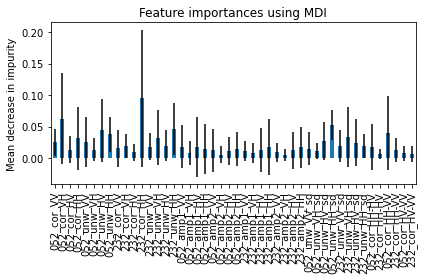

In [118]:
# regr = RandomForestRegressor(max_depth=10, random_state=0)
clf.fit(X_train, y_train)
print('Training score: ', clf.score(X_train, y_train))
print('Testing score: ', clf.score(X_test, y_test))

importances = clf.named_steps['classifier'].feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.named_steps['classifier'].estimators_], axis=0)

forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()